In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

from networkx.algorithms import bipartite

In [2]:
"""
Definitions
"""
random.seed('Zufall!!')
mapWidth = 500
mapHeight = 250

### Skills
Im Folgenden wird die Klasse _Skills_ implementiert. Sie repräsentiert einen Skill mit definierten Namen. Wird kein Name zur Initialisierung übergeben, wird ein Namen aus der ID (fortlaufende Nummer über alle initialisierten Skills) generiert.
Danach werden beispielhaft vier Skills initialisiert. 

In [3]:
class Skill:
    count = 0
    
    def __init__(self, name=None):
        self._id = Skill.count
        Skill.count += 1
        
        if name is None:
            self.name = "Skill " + str(self._id)
        else:
            self.name = name
            
            
    def __str__(self):
        return self.name

In [4]:
sBaggern = Skill("baggern"); sMauern = Skill("mauern")
sHeben = Skill("heben"); sMischen = Skill("mischen"); 

skills = [sBaggern, sMauern, sHeben, sMischen, ]
print "Skills: " + ", ".join([str(skill) for skill in skills])

Skills: baggern, mauern, heben, mischen


## Skillkapazitäten und Agenten (Baufirma)
### Skillkapazität
Agenten (Baufirmen) bieten Skills nicht einzeln, sondern als Skillkapazität (Klasse `SkillCap`) an (in einer Skillkapazität kann der Skill nur einmal vorhanden sein). Die Kosten des Agentens für die Bereitstellung der kompletten Skillkapazität oder eines Teiles werden über eine spezifische Kostenfunktion berechnet. Diese wird bei der Initialisierung der Klasse übergeben und errechnet die Kosten auf Grundlage der Menge des angeforderten Skills und der Entfernung zwischen Agent und Baustelle. Es wird hier also die Kostenfunktion »$Costs(t, n, x, y) :\Leftrightarrow$ Kosten für Agenten $x$ für $n$ Einheiten des Skils $t$ an die Baustelle $y$« für jede Skillkapazität verwaltet.

Beispielhaft initialisieren wir zwei verschiedenen Skillkapazitäten mit unterschiedlicher Kostenfunktion und lassen uns zwei Preise ermitteln.

In [5]:
class SkillCap:
    count = 0
    
    def __init__(self, skill, capacity, costFunction):
        """ Initialisiere eine Skillkapazität mit Skill, Menge und Kostenfunktion. """
        
        self._id = SkillCap.count
        SkillCap.count += 1
        
        self.skill = skill
        self.capacity = self.actCapacity = capacity
        self.costFunction = costFunction
        self.costF = eval(costFunction)
        
    def __str__(self):
        return str(self.skill) + "(" + str(self.actCapacity) + ")"
    
    
    def costs(self, distance, count):
        """ Kosten für eine Menge der Skillkapazität. """
        
        if  0 < count and count <= self.actCapacity:
            return self.costF(count, distance)
        else:
            raise Exception("SkillCap", "getCosts()")

In [6]:
sk0 = SkillCap(sBaggern, 10, 'lambda k,d: (k/3+1)*d + 200*k')  # 10 items, 3 items per shipment, one item 200
sk1 = SkillCap(sMauern,   8, 'lambda k,d: (k/3+1)*d + 215*k')  #  8 items, 3 items per shipment, one item 215
print "Skillkapazitäten: " + str(sk0) + ", " + str(sk1)

print "Kosten für 2 Items sk0, Distanz 5: " + str(sk0.costs(5, 2))
print "Kosten für 4 Items sk0, Distanz 5: " + str(sk0.costs(5, 4))

Skillkapazitäten: baggern(10), mauern(8)
Kosten für 2 Items sk0, Distanz 5: 405
Kosten für 4 Items sk0, Distanz 5: 810


### Agent (Baufirma)
Eine Agent (Baufirma, Klasse `Agent`) sitzt in unserem Spiel auf einem bestimmten Punkt im 2D-Raum und hält Skillkapazitäten bereit. Im Laufe des Spiel verkauft er diese an Baustellen. In dieser Klasse wird für den instanziierten Agenten $x$ die Funktion »$Supply(x, t) \mapsto n :\Leftrightarrow$ Agent $x$ besitzt $n$ Einheiten vom Skill $t$« verwaltet. Die Kostenfunktion »$Costs(t, n, x, y)« kann bei dem Agenten für jede seine Skillkapazitäten abgefragt werden.

Im Folgenden wird ein Agenten mit den weiter oben definierten Skillkapazitäten erstellt. Der Agent verkauft danach zwei Einheiten "baggern" an eine Baustelle, die 5 Einheiten entfernt liegt.

In [7]:
class Agent:
    count = 0
    
    def __init__(self, skillCaps, x=None, y=None):
        """ Initialisieren eines Agenten mit übergebenen Skillkapazitäten. Werden keine Koordinaten übergeben, 
            wird der Agent zufällig auf der Karte platziert. """
        
        self._id = "A"+str(Agent.count)
        Agent.count += 1
        
        self.skillCaps = skillCaps
        if x is None: self.x = random.uniform(0, mapWidth)
        else: self.x = x
        if y is None: self.y = random.uniform(0, mapHeight)
        else: self.y = y
    
    def __str__(self):
        skillString = ""
        if len(self.skillCaps) > 0:
            skillString = ": " + ", ".join([str(skillCap) for skillCap in self.skillCaps])
        
        return("Agent " + str(self._id) + skillString)
    
    
    @property
    def supply(self):  # Agent, Skill, Menge
        return np.array([(self._id, str(skillCap.skill), str(skillCap.capacity)) for skillCap in self.skillCaps])
    
    @property
    def costs(self):  # Agent, Skill, Kostenfunktion
        return np.array([(self._id, str(skillCap.skill), skillCap.costFunction) for skillCap in self.skillCaps])
    
        
    def sell(self, skill, count, distance):
        """ Verkaufen eines Teiles oder einer gesamten Skillkapazität. 
            Die Kosten für den Agenten nach der Kostenfunktion der Skillkapazität
            werden zurückgegeben. """ 
        
        # find skillCap for this skill
        skillCap = [skillC for skillC in self.skillCaps if skillC.skill == skill][0]
               
        if skillCap is not None and 0 < skillCap.count and count <= skillCap.actCapacity:
            skillCap.actCapacity -= count
            return skillCap.costF(distance, count)
        else:
            raise Exception("Agent", "sell()")

In [8]:
# Agenten erstellen mit den obigen Skillkapazitäten
agent0 = Agent((sk0, sk1))
print agent0

# Verkauf von 2 Einheiten des Skills "baggern" über die Distanz von 5
print "Agent verkauft 2 Einheiten \"baggern\" über die Distanz 5 mit den Kosten " + \
       str(agent0.sell(sBaggern, 2, 5))
print agent0

Agent A0: baggern(10), mauern(8)
Agent verkauft 2 Einheiten "baggern" über die Distanz 5 mit den Kosten 1004
Agent A0: baggern(8), mauern(8)


## Ausschreibungen und Baustellen
### Ausschreibung
In einer Ausschreibung (Klasse `SkillReq`) wird die von einer Baustelle gewünschte Menge eines Skills festgehalten. Beispielhaft erstellen wir zwei Requests.

In [9]:
class SkillReq:
    count = 0
    
    def __init__(self, skill, amount):
        """ Initialisiere einer Ausschreibung mit Skill und Menge. """
    
        self._id = SkillReq.count
        SkillReq.count += 1
        
        self.skill = skill
        self.amount = self.actAmount = amount
    
    
    def __str__(self):
        return str(self.skill) + "(" + str(self.actAmount) + ")"

In [10]:
# Definition zweier Ausschreibungen
req0 = SkillReq(sBaggern, 5)
req1 = SkillReq(sMauern, 5)
print "Requests: " + str(req0) + ", " + str(req1)

Requests: baggern(5), mauern(5)


### Baustelle
Im Laufe des Spiel sind es die Baustellen (Klasse `Site`), deren Ausschreibungen im Rahmen ihres Budgets möglichst preiswert von den Agenten erfüllt werden sollen. Auch sie sind fest im Koordinatensystem einem Ort zugeordnet.

Beispielhaft wird eine Baustelle mit Budget 2.000 erstellt, die fünf Einheiten "baggern" und "mauern" benötigt. Sie kauft im Folgenden 3 Einheiten des Skills "baggern" für 1.200.

In [11]:
class Site:
    count = 0
    
    def __init__(self, requests, budget, x=None, y=None):
        """ Initialisiere einer Baustelle mit übergebenen Request. Werden keine Koordinaten übergeben, 
            wird die Baustelle zufällig auf der Karte platziert. """
        
        self._id = "B"+str(Site.count)
        Site.count += 1
        
        self.requests = requests
        self.bud = self.actBudget = budget
        if x is None: self.x = random.uniform(0, mapWidth)
        else: self.x = x
        if y is None: self.y = random.uniform(0, mapHeight)
        else: self.y = y
    
    def __str__(self):
        requestString = ""
        if len(self.requests) > 0:
            requestString = ": " + ", ".join([str(request) for request in self.requests])
        
        return("Baustelle " + str(self._id) + " (Budget: " + str(self.actBudget) + ")" + requestString)
    
    @property
    def demand(self):  # Baustelle, Skill, Menge
        return np.array([(self._id, str(request.skill), request.amount) for request in self.requests])
    
    @property
    def budget(self):  # Baustelle, Budget
        return [self._id, self.bud]
    
    def buy(self, skill, count, price):
        """ Kaufen einer Menge des Skills: Der Request wird entsprechend angepasst. """
        
        # find skillReq for this skill
        skillReq = [skillR for skillR in self.requests if skillR.skill == skill][0]
               
        if skillReq is not None and 0 < skillReq.actAmount and count <= skillReq.actAmount:
            skillReq.actAmount -= count
            self.actBudget -= price
        else:
            raise Exception("Site", "buy()")

In [12]:
# Initialisieren einer Baustelle mit den weiter oben definierten 
# Ausschreibungen
site0 = Site([req0, req1], 2000)
print site0

# Kauf von drei Einheiten Baggern für 1020
site0.buy(sBaggern, 3, 1020)
print "Baustelle kauft drei Einheiten \"baggern\" für 1020 \n" + str(site0)

Baustelle B0 (Budget: 2000): baggern(5), mauern(5)
Baustelle kauft drei Einheiten "baggern" für 1020 
Baustelle B0 (Budget: 980): baggern(2), mauern(5)


## Szenario

In [13]:
class Scenario:
    
    
    def __init__(self, agentCount=2, siteCount=2, skills=[Skill("mauern"), Skill("baggern")], \
                 skillCap=[[10,20],[15,10]], skillReq=[[7,15],[8,8]], budget=[100000], \
                 costFunction=[['lambda k,d:(k/5+1)*d+200*k', 'lambda k,d:(k/3+1)*d+250*k']], \
                 agents=None, sites=None):
        """ Initialisierung eines Szenarios: Ohne die weitere Angabe von Parametern wird ein Szenario mit zwei Agenten 
            und einer Baustelle erstellt, die zwei Skills ("mauern" und "baggern") in der Menge (10,20) für Agent 1 
            und (15,10) für Agent 2 als Skillkapazität besitzen bzw. Baustelle 1 (7,15) und Baustelle 2 (8,8) suchen.
            Es gibt für die Skillkapazitäten Standardkostenfunktionen, die z.B. für den ersten Skill von Kosten von 
            200 per item und Shipmentkosten von $distance je 5 items ausgeht. Von dem dritten Skill könne nur 3 auf 
            einmal transportiert werden und eine Einheit kostet 250. Das Defaultbudget der Baustellen beträgt 100.000. 
            
            Alternativ hätte auch für jeden Agenten eine eigene Kostenfunktion bzw. jede Baustelle ein eigenes Budget 
            definiert werden können. Wenn Baustellen und Agenten bereits der Funktion übergeben werden (als Iterable),
            so werden diese benutzt. """
        
        self.skills = skills
        self.sales  = None
        
        # Are there complete sites? ############
        if sites is not None:
            self.sites = sites
        else:
            # check if budget sitewise or for all sites?
            if len(budget) == 1:
                budget = budget * siteCount
            elif len(budget) != siteCount:
                raise Exception("Scenario", "__init__()", "site-budget")
            
            # check skill requests
            if len(skillReq) == 1:
                skillReq = skillReq * siteCount
            elif len(skillReq) != siteCount:
                raise Exception("Scenario", "__init__()", "site-requests")
                
            # create sites
            self.sites = list()
            for site in range(siteCount):
                
                # create Skill Requests
                sk = list()
                if len(skillReq[site]) == len(skills):
                    for i, skill in enumerate(skills):
                        sk.append(SkillReq(skill, skillReq[site][i]))
                elif len(skillReq) != siteCount:
                    raise Exception("Scenario", "__init__()", "site-requests-creation")

                self.sites.append(Site(sk, budget[site]))
        
        # Are there complete agents? ############
        if agents is not None:
            self.agents = agents
        else:
            # check if costFunction sitewise or for all sites?
            if len(costFunction) == 1:
                costFunction = costFunction * agentCount
            elif len(costFunction) != agentCount:
                raise Exception("Scenario", "__init__()", "agent-costFunction")
            
            # check skill capacities
            if len(skillCap) == 1:
                skillCap = skillCap * agentCount
            elif len(skillCap) != agentCount:
                raise Exception("Scenario", "__init__()", "aget-capabilities")
                
            # create agents
            self.agents = list()
            for agent in range(agentCount):
                
                # create Skill Capacities
                sk = list()
                if len(skillCap[agent]) == len(skills):
                    for i, skill in enumerate(skills):
                        sk.append(SkillCap(skill, skillCap[agent][i], costFunction[agent][i]))
                elif len(skillReq) != siteCount:
                    raise Exception("Scenario", "__init__()", "agent-cap-creation")
                    
                self.agents.append(Agent(sk))
     
        
    def __str__(self):
        """ Ausgabe des Szenarios in der definierten Algebra-Schreibweise. """
        
        supply  = [ ", ".join([elem[0], elem[1], elem[2]]) for elem in list(self.supply)]
        demand  = [ ", ".join([elem[0], elem[1], elem[2]]) for elem in list(self.demand)]
        budget  = [ ", ".join([elem[0], elem[1]]) for elem in list(self.budget)]
        costs   = [ ", ".join([elem[0], elem[1], elem[2]]) for elem in list(self.costs)]
        matches = [ ", ".join([elem[0], elem[1], elem[2], elem[3], elem[4]]) for elem in list(self.matches)]
        
        return "Agenten: " + ", ".join(self.agent) + "\nBaustellen: " + ", ".join(self.site) + "\n" + \
               "Supply: " +  "("+"), (".join(supply)+")" + "\nDemand: " +"("+"), (".join(demand)+")\n" + \
               "Budget: " + "("+"), (".join(budget)+")" + "\nCosts: " +"("+"), (".join(costs)+")\n" + \
               "Matches: "+ "("+"), (".join(matches)+")" 
    
    @property
    def agent(self):   # Agent
        return np.array([agent._id for agent in self.agents])
    
    @property
    def site(self):    # Baustelle
        return np.array([site._id for site in self.sites])
                                           
    @property
    def supply(self):  # Agent, Skill, Menge
        return np.concatenate([agent.supply for agent in self.agents], axis=0)
    
    @property
    def demand(self):  # Baustelle, Skill, Menge
        return np.concatenate([site.demand for site in self.sites], axis=0)
    
    @property
    def budget(self):  # Baustelle, Budget
        return np.array([site.budget for site in self.sites])
    
    @property
    def costs(self):   # Agent, Skill, Kostenfunktion
        return np.concatenate([agent.costs for agent in self.agents])
    
    @property
    def matches(self): # Agent, Baustelle, Skill, Menge, Preis
        return self.sales[0:5] if self.sales is not None else list()
    
    
    def match(self, agent, site, skill, amount, price):
        """ Über diese Funktion wird ein Verkaufsvorgang durchgeführt bzw. ein Matching eingetragen. 
            Dieser Vorgang wird beschrieben durch den verkaufenden Agente, der kaufenden Baustelle, 
            den verhandelten Skill und den von der Baustelle bezahlten Preis. Damit wird bessere """
        
        # Kriegen wir Objekte oder IDs?
        if isinstance(agent, basestring): 
            agent = [elem for elem in self.agents if elem._id == agent][0]
        if isinstance(site, basestring): 
            site = [elem for elem in self.sites if elem._id == site][0]
        if isinstance(skill, basestring): 
            skill = [elem for elem in self.skills if str(elem) == skill][0]
        
        costs = agent.sell(skill, amount, self.distance(agent, site))
        site.buy(skill, amount, price)
        if self.sales is None:
            self.sales = np.array([[agent._id, site._id, str(skill), str(amount), price, costs]])
        else:
            self.sales = np.vstack([self.sales, [[agent._id, site._id, str(skill), str(amount), price, costs]]])
            

    def distance(self, a, b):
        """ Euklidische Distanz zwischen den zwei Punkten a und b mit den jeweiligen Koordinaten 
            x und y im zweidimensionalen Koordinatensystem. """
        return ( ((a.x-b.x)**2) + ((a.y-b.y)**2) )**0.5
    
    
    def plotBiGraph(self):
        # create nx-Graph
        B = nx.Graph()
        B.add_nodes_from([agent._id for agent in self.agents], bipartite=0)
        B.add_nodes_from([site._id for site in self.sites], bipartite=1)
        if self.sales is not None:
            B.add_edges_from([(match[0], match[1]) for match in self.sales])
        
        # left or right?
        pos = dict()
        pos.update( (agent._id, (1, i)) for i, agent in enumerate(self.agents) )
        pos.update( (site._id, (2, i)) for i, site in enumerate(self.sites) )
        
        # formating for plotting
        color  = ['b'] * len(self.agents)
        color += ['g'] * len(self.sites)
        
        edgeLabels = dict()
        if self.sales is not None:
            edgeLabels.update( [((match[0], match[1]), \
                "Skill: "+str(match[2])+"("+str(match[3])+")"+" -> \n <- Preis: "+str(match[4])) for match in self.sales])
        
        nx.draw_networkx_edge_labels(B, pos=pos, edge_labels=edgeLabels)
        nx.draw_networkx(B, pos=pos, with_labels=True, node_size=700, node_color=color)
        plt.axis('off')
        plt.show()
        
    def plotMap(self):
        # data
        agent = np.array([[agent.x, agent.y, agent._id, str(agent), 'b'] for agent in self.agents])
        site = np.array([[site.x, site.y, site._id, str(site), 'g'] for site in self.sites])
        plot = np.vstack([agent, site])
        
        # Plot
        fig = plt.figure(1, figsize=(8,5))
        ax = plt.subplot(111)
        
        for i in range(len(plot)):
            ax.scatter(plot[i,0], plot[i,1], s=150, marker="8", label=plot[i,3], c=plot[i,4])
        
        for i, txt in enumerate(plot[:,2]):
            ax.annotate(txt, (plot[i,0], plot[i,1]), xytext=(float(plot[i,0])+10, float(plot[i,1])-5))
        
        ax.set_xticks(np.arange(0,mapWidth,50))
        ax.set_yticks(np.arange(0,mapHeight,25))

        plt.xlim(0, mapWidth)
        plt.ylim(0, mapHeight)
        plt.grid()
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
    

Agenten: A1, A2
Baustellen: B1, B2
Supply: (A1, mauern, 10), (A1, baggern, 20), (A2, mauern, 15), (A2, baggern, 10)
Demand: (B1, mauern, 7), (B1, baggern, 15), (B2, mauern, 8), (B2, baggern, 8)
Budget: (B1, 100000), (B2, 100000)
Costs: (A1, mauern, lambda k,d:(k/5+1)*d+200*k), (A1, baggern, lambda k,d:(k/3+1)*d+250*k), (A2, mauern, lambda k,d:(k/5+1)*d+200*k), (A2, baggern, lambda k,d:(k/3+1)*d+250*k)
Matches: ()


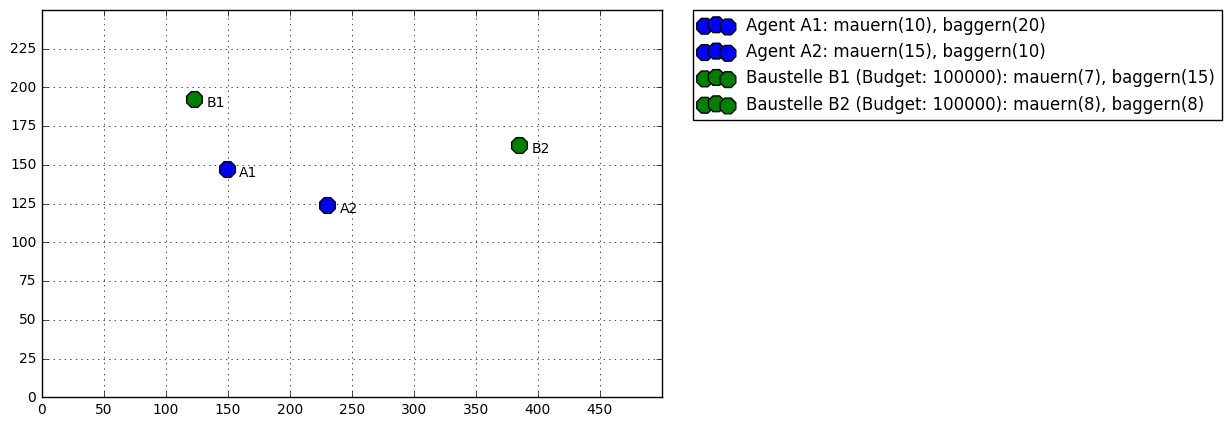

In [14]:
scenario = Scenario()
print scenario
scenario.plotMap()

Agenten: A1, A2
Baustellen: B1, B2
Supply: (A1, mauern, 10), (A1, baggern, 20), (A2, mauern, 15), (A2, baggern, 10)
Demand: (B1, mauern, 7), (B1, baggern, 15), (B2, mauern, 8), (B2, baggern, 8)
Budget: (B1, 100000), (B2, 100000)
Costs: (A1, mauern, lambda k,d:(k/5+1)*d+200*k), (A1, baggern, lambda k,d:(k/3+1)*d+250*k), (A2, mauern, lambda k,d:(k/5+1)*d+200*k), (A2, baggern, lambda k,d:(k/3+1)*d+250*k)
Matches: (A1, B1, baggern, 5, 2000), (A1, B2, mauern, 3, 1000)


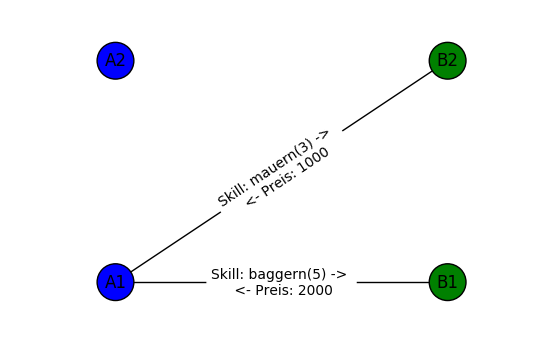

In [15]:
scenario.match(scenario.agents[0], scenario.sites[0], 'baggern', 5, 2000)
scenario.match(scenario.agents[0], scenario.sites[1], 'mauern', 3, 1000)
print scenario
scenario.plotBiGraph()

## Simple Reverse Auction

In [ ]:
def simpleReverseAuction(scenario):

    auctions = list() # site, skill, menge, budget, bids[agent][bid], bidsLastRound
    
    # Rundenweises Spielen: Zunächst alle Baustellen, danach alle Agenten
    for site in scenario.sites:
        
        if round == 0: # Auktionen aufstellen
            budgetPU = site.budget/sum(site.demand[2]) # Budget pro Einheit (Vereinfachung)
            auctions.extend( [(req[0], req[1], req[2], req[2]*budgetPU, \
                               np.array(), None)  for req in site.demand] )
            
        else: # Reaktion auf letzte Bierterrunde
            for auction in auctions:
                
                # get minimum bid
                minBid = min(auction[4])
                lastRoundBids = 
                
                if auction[5] is not None and \ # es gabe schon eine Runde
                   minBid >= min(auction[5][4][2]): # Minimum in dieser Runde nicht kleiner
                    
                    # wähle Sieger der Aktion, beende sie und trage Match ein
                    # (wenn mehrere, zufällig)
                    agentsMinBid = []
                    
                else: # bereite neue Runde vor: neues Budget ist das niedrigste Gebot
                    auction[3] = minBid
                    auction[5] = auction[4]
                    auction[4] = np.array()
                    
                    
        
    for agent in scenario.agents:
        
        
revScenario = Scenario()
